# 概要
学習済みのモデルを使って、歌詞からアーティスト名の予測＆LIMEによる解釈を可視化します。

# 準備

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm
import copy
import os
import json

import torch
import torch.nn as nn
import torch.nn.functional as F

from lime.lime_text import LimeTextExplainer

from IPython.display import display, HTML
from janome.tokenizer import Tokenizer
import unicodedata

In [3]:
# 保存先のパス
PATH = './models/'

In [4]:
class CharacterCNN(nn.Module):
    def __init__(self, num_classes ,embed_size=128, max_length=200, filter_sizes=(2, 3, 4, 5), filter_num=64):
        super().__init__()
        self.params = {'num_classes': num_classes ,'embed_size':embed_size, 'max_length':max_length, 'filter_sizes':filter_sizes, 'filter_num':filter_num}
        self.embed_size = embed_size
        self.max_length = max_length
        self.filter_sizes = filter_sizes
        self.filter_num = filter_num

        self.embedding = nn.Embedding(0xffff, embed_size)
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(embed_size, filter_num, filter_size) for filter_size in filter_sizes
        ])
        self.fc1 = nn.Linear(filter_num * len(filter_sizes), 64)
        self.batch_norm = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        embedded = self.embedding(x).transpose(1,2)

        conv_outputs = []
        for conv_layer in self.conv_layers:
            conv_output = F.relu(conv_layer(embedded))
            pooled = F.max_pool1d(conv_output, conv_output.size(2)).squeeze(2)
            conv_outputs.append(pooled)

        convs_merged = torch.cat(conv_outputs, dim=1)
        fc1_output = F.relu(self.fc1(convs_merged))
        bn_output = self.batch_norm(fc1_output)
        do_output = self.dropout(bn_output)
        fc2_output = self.fc2(do_output)
        return fc2_output

In [5]:
def encode(txt, max_length=200):
    """歌詞の1文字1文字をUnicodeに変換する関数"""
    txt_list = []
    for l in txt:
        txt_line = [ord(x) for x in str(l).strip()]
        txt_line = txt_line[:max_length]
        txt_len = len(txt_line)
        if txt_len < max_length:
            txt_line += ([0] * (max_length - txt_len))
        txt_list.append((txt_line))
    return np.array(txt_list)

In [6]:
def predict_one(txt, models):
    """歌詞1ブロックに対する予測を行う関数"""
    txt = txt.strip().replace('\n','*').replace('\u3000','*')
    txt_enc = torch.from_numpy(encode([txt]))
    probs = []
    for model in models:
        with torch.no_grad():
            model.eval()
            device = 'cuda' if next(model.parameters()).is_cuda else 'cpu'
            output = model(txt_enc.to(device))
            probs.append(output.softmax(dim=1).cpu().numpy()[0])
    prob = np.array(probs).mean(axis=0)
    return prob, txt

def predict_fn(txt_list):
    """LIME用の推論関数(歌詞ブロック版)"""
    txt_arr = []
    for txt in txt_list:
        txt = txt.replace(' ','')
        txt = txt.strip().replace('\n','*').replace('\u3000','*')
        txt_arr.append(txt)
    txt_enc = torch.from_numpy(encode(txt_arr))
    probs = []
    for model in models:
        with torch.no_grad():
            model.eval()
            device = 'cuda' if next(model.parameters()).is_cuda else 'cpu'
            output = model(txt_enc.to(device))
            probs.append(output.softmax(dim=1).cpu().numpy())
    prob = np.array(probs).mean(axis=0)
    return prob

def predict_fn2(txt_list):
    """LIME用の推論関数(歌詞全体版)"""
    prob_arr = []
    for txt in txt_list:
        prob_arr.append(predict_fn(txt.split('\n\n')).mean(axis=0))
    return np.array(prob_arr)

def plot_prediction(prob, artists, title, figsize=(10,3), fontsize=8):
    """予測結果を可視化する関数(歌詞ブロック版)"""
    plt.figure(figsize=figsize)
    plt.bar(artists, prob, color='green', zorder=100)
    for i,p in enumerate(prob):
        plt.text(i, p+0.05, f'{int(p*100)}%', horizontalalignment='center', zorder=100)
    plt.title(title, fontsize=fontsize)
    plt.xticks(rotation=90)
    plt.ylim(0,1)
    plt.grid()
    plt.show()

def plot_prediction2(prob_arr, raw_txt_arr, artists, figsize=(10,3)):
    """予測結果を可視化する関数(歌詞全体版)"""
    fig,axs = plt.subplots(1,2, figsize=figsize)
    # 各ブロックの予測値
    df = pd.DataFrame(prob_arr, columns=artists,index=raw_txt_arr)
    df.plot.bar(stacked=True, cmap='tab20b', ax=axs[0], zorder=100)
    axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[0].set_xticks(range(len(df.index)), labels=df.index, rotation=90)
    axs[0].set_xlabel('block')
    axs[0].grid()
    axs[0].set_title('各ブロックの予測値')
    # 予測値の平均
    axs[1].bar(artists, prob_arr.mean(axis=0), color='green', zorder=100)
    for i,p in enumerate(prob_arr.mean(axis=0)):
        axs[1].text(i, p+0.05, f'{int(p*100)}%', horizontalalignment='center', zorder=100)
    axs[1].set_xticks(range(len(artists)), labels=artists, rotation=90)
    axs[1].set_ylim(0,1)
    axs[1].grid()
    axs[1].set_title('平均値')
    plt.tight_layout()
    plt.show()

def wakachi(txt):
    """日本語テキストを分かち書きする(歌詞ブロック版)"""
    txt = txt.replace('\u3000','')
    tokenizer = Tokenizer()
    tokens = tokenizer.tokenize(txt)
    words = [token.surface for token in tokens]
    txt_split = []
    line = []
    for i,word in enumerate(words):
        if word == '\n':
            txt_split.append(' '.join(line))
            line = []
        else:
            line.append(word)
    txt_split.append(' '.join(line))
    return '\n'.join(txt_split)

def wakachi2(txt):
    """日本語テキストを分かち書きする(歌詞全体版)"""
    wakachi_txt = ''
    for block in txt.split('\n\n'):
        wakachi_txt += wakachi(block) + '\n\n'
    return wakachi_txt

def highlight(exp, wakachi_txt):
    """LIMEの結果をハイライト表示"""
    highlighted_text = '<h2><span style="color: black; background-color: rgba(255,128,0,1);">ぽい</span> / <span style="color: black; background-color: rgba(0,128,255,1);">ぽくない</span>判定理由</h2>'
    for label in range(len(artists)):
        words = [word for word, weight in exp.as_list(label)]
        weights = np.array([weight for word, weight in exp.as_list(label)])
        weights_alpha = weights / np.abs(weights).max()
        alpha_dict = {word:alpha for word,alpha in zip(words,weights_alpha)}

        highlighted_text += f'<h3>「{artists[label]}」っぽさ</h3><div style="overflow:auto; max-height:300px; max-width:600px;border: 2px solid black; padding: 20px; box-sizing: border-box"><p style="line-height: 2;">'
        for line in wakachi_txt.split('\n'):
            for word in line.split(' '):
                try:
                    alpha = alpha_dict[word]
                    if alpha > 0:
                        bg_color = (255,128,0,alpha)
                    else:
                        bg_color = (0,128,255,-alpha)
                    highlighted_text += f'<span style="color: black; background-color: rgba{bg_color};">{word}</span> '
                except KeyError:
                    highlighted_text += word
            highlighted_text += '<br>'
        highlighted_text += '</p></div><br>'
    return highlighted_text

# 使用するモデルの選択

In [38]:
# @title 学習済みモデル一覧
# @markdown - このコードを実行すると、学習済みモデルの一覧が表示されます。
# @markdown - 番号はモデルIDを表します。
# @markdown - IDの右には、そのモデルで分類対象としているアーティストの一覧が表示されます。
dirname_dict = dict()
artist_dict = dict()
for i,dir in enumerate(os.listdir(PATH)):
    # file = unicodedata.normalize('NFKC', file)
    dirname_dict[i] = dir
    for file in os.listdir(PATH + dir):
        if file == 'info.json':
            with open(PATH + dir + '/info.json', 'r') as f:
                info = json.load(f)
                dirname_dict[i] = dir
                artist_dict[i] = info['ClassNames']
                print(i, info['ClassNames'])

0 ['YOASOBI', 'スピッツ', 'Mr.Children', '米津玄師', 'SEKAI NO OWARI', 'あいみょん', 'King Gnu', 'Mrs. GREEN APPLE', 'Official髭男dism', '安室奈美恵', 'back number', 'ヨルシカ', 'BUMP OF CHICKEN', 'ONE OK ROCK', 'RADWIMPS', "B'z", 'ゆず', '嵐', 'GreeeeN', 'サザンオールスターズ', '宇多田ヒカル', '星野源', 'ポルノグラフィティ', 'Eve', 'Ado', 'BTS', '中島みゆき', '緑黄色社会', '倖田來未', '優里', 'いきものがかり', 'ZARD', '椎名林檎', '小田和正', 'TWICE', 'Perfume', 'Uru', 'Superfly', 'aiko', 'Aimer', '三代目 J SOUL BROTHERS']
1 ['YOASOBI', 'スピッツ', 'Mr.Children', '米津玄師', 'SEKAI NO OWARI', 'あいみょん', 'King Gnu', 'Mrs. GREEN APPLE', 'Official髭男dism', '安室奈美恵', 'back number', 'ヨルシカ']
2 ['BUMP OF CHICKEN', 'ONE OK ROCK', 'RADWIMPS', "B'z", 'ゆず', '嵐', 'GreeeeN', 'サザンオールスターズ', '宇多田ヒカル', '星野源', 'ポルノグラフィティ', 'Eve']
3 ['Ado', 'BTS', '中島みゆき', '緑黄色社会', '倖田來未', '優里', 'いきものがかり', 'ZARD', '椎名林檎', '小田和正', 'TWICE', 'Perfume']
4 ['Uru', 'Superfly', 'aiko', 'Aimer', '三代目 J SOUL BROTHERS']
5 ['YOASOBI', 'スピッツ']
6 ['Mr.Children', '米津玄師']
7 ['SEKAI NO OWARI', 'あいみょん']
8 ['King Gnu', 'Mrs. GREEN APPLE'

In [75]:
# @title モデル選択
# @markdown - 変数`MODEL_ID`に使用したいモデルIDを格納し、下のコードを実行してください。モデルが読み込まれます。
# @markdown - また、選択されたモデルの情報（精度など）が表示されます。
MODEL_ID = 14  # @param {type:'number'}
models = []
for model_file in os.listdir(PATH + dirname_dict[MODEL_ID]):
    if model_file.endswith('.pth'):
        models.append(torch.load(PATH + dirname_dict[MODEL_ID] + '/' + model_file))
artists = artist_dict[MODEL_ID]
explainer = LimeTextExplainer(class_names=artists)

# モデルの情報を表示
with open(PATH + dirname_dict[MODEL_ID] + '/info.json', 'r') as f:
    info = json.load(f)
print('# クラス名')
print(info['ClassNames'])
print('\n# 正解率(評価用データ)')
for fold,data in info.items():
    if 'Fold' in fold:
        print(f'{fold}:{data["ValidAcc"]: .2f}%', end='  ')
print('\n# 正解率(学習用データ)')
for fold,data in info.items():
    if 'Fold' in fold:
        print(f'{fold}:{data["TrainAcc"]: .2f}%', end='  ')
print('\n\n# CrossEntropyLoss(評価用データ)')
for fold,data in info.items():
    if 'Fold' in fold:
        print(f'{fold}:{data["ValidLoss"]: .5f}', end='  ')
print('\n# CrossEntropyLoss(学習用データ)')
for fold,data in info.items():
    if 'Fold' in fold:
        print(f'{fold}:{data["TrainLoss"]: .5f}', end='  ')
print('\n\n# 学習データ数:', info['Fold1']['ValidSize']*5)

print('\n# モデルのハイパーパラメータ')
print(info['Fold1']['Params'])

# クラス名
['あいみょん', 'スピッツ', '星野源', 'YOASOBI']

# 正解率(評価用データ)
Fold1: 65.23%  Fold2: 73.71%  Fold3: 67.24%  Fold4: 66.09%  Fold5: 67.10%  
# 正解率(学習用データ)
Fold1: 100.00%  Fold2: 100.00%  Fold3: 100.00%  Fold4: 99.96%  Fold5: 99.96%  

# CrossEntropyLoss(評価用データ)
Fold1: 1.06177  Fold2: 0.79879  Fold3: 0.92024  Fold4: 0.93643  Fold5: 0.88807  
# CrossEntropyLoss(学習用データ)
Fold1: 0.02992  Fold2: 0.02795  Fold3: 0.04347  Fold4: 0.04195  Fold5: 0.04290  

# 学習データ数: 3480

# モデルのハイパーパラメータ
{'num_classes': 4, 'embed_size': 128, 'max_length': 200, 'filter_sizes': [2, 3, 4, 5], 'filter_num': 64}


# 推論と解釈

## 1ブロック分の歌詞
- `txt`に歌詞1ブロック分を入力してください。
- `figsize`でグラフのサイズを調整できます。
- `num_samples`で、LIMEにおいてサンプルする近傍店の個数を指定できます。値が大きいほどLIMEの計算に時間がかかります。
- LIME表示用の分かち書きは自動生成されますが、`wakachi_txt`(カスタム分かち書き)に自分で分かち書きした歌詞も入れることができます。`txt`に入力した歌詞を**半角スペース**で分かち書きしたものを入れてください。

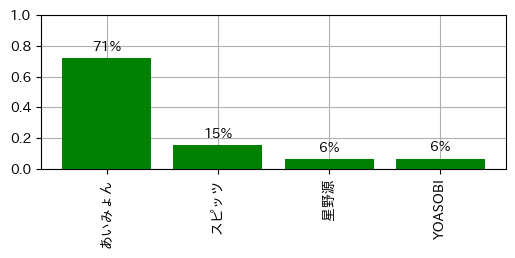

In [35]:
txt = """
麦わらの帽子の君が
揺れたマリーゴールドに似てる
あれは空がまだ青い夏のこと
懐かしいと笑えたあの日の恋
"""
figsize = (6,2)  # グラフのサイズを調整 (横,縦)
num_samples = 100  # サンプルする近傍点の個数

# 分類結果の取得
prob,raw_txt = predict_one(txt, models)
# 棒グラフで可視化
plot_prediction(prob, artists, '', figsize)

# カスタム分かち書き ###############
wakachi_txt = """
"""

# LIME
if wakachi_txt == '\n':
    wakachi_txt = wakachi(txt)
exp = explainer.explain_instance(wakachi_txt, predict_fn, num_features=200, labels=range(len(artists)), num_samples=num_samples)
highlighted_text = highlight(exp, wakachi_txt)
display(HTML(highlighted_text))

## 歌詞全体
- `txt`に歌詞全体を入力してください。ブロック間は改行を1つはさんでください。
- `figsize`でグラフのサイズを調整できます。
- `num_samples`で、LIMEにおいてサンプルする近傍店の個数を指定できます。値が大きいほどLIMEの計算に時間がかかります。

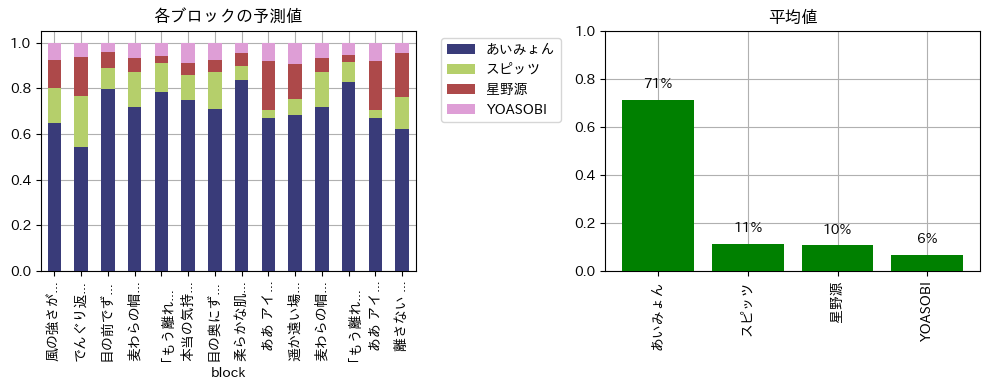

In [36]:
txt = """
風の強さがちょっと
心を揺さぶりすぎて
真面目に見つめた
君が恋しい

でんぐり返しの日々
可哀想なふりをして
だらけてみたけど
希望の光は

目の前でずっと輝いている
幸せだ

麦わらの帽子の君が
揺れたマリーゴールドに似てる
あれは空がまだ青い夏のこと
懐かしいと笑えたあの日の恋

「もう離れないで」と
泣きそうな目で見つめる君を
雲のような優しさでそっとぎゅっと
抱きしめて　抱きしめて　離さない

本当の気持ち全部
吐き出せるほど強くはない
でも不思議なくらいに
絶望は見えない

目の奥にずっと写るシルエット
大好きさ

柔らかな肌を寄せあい
少し冷たい空気を2人
かみしめて歩く今日という日に
何と名前をつけようかなんて話して

ああ　アイラブユーの言葉じゃ
足りないからとキスして
雲がまだ2人の影を残すから
いつまでも　いつまでも　このまま

遥か遠い場所にいても
繋がっていたいなあ
2人の想いが
同じでありますように

麦わらの帽子の君が
揺れたマリーゴールドに似てる
あれは空がまだ青い夏のこと
懐かしいと笑えたあの日の恋

「もう離れないで」と
泣きそうな目で見つめる君を
雲のような優しさでそっとぎゅっと
抱きしめて離さない

ああ　アイラブユーの言葉じゃ
足りないからとキスして
雲がまだ2人の影を残すから
いつまでも　いつまでも　このまま

離さない
いつまでも　いつまでも　離さない
"""
figsize = (10,4)  # グラフのサイズを調整 (横,縦)
num_samples = 100  # サンプルする近傍点の個数

# 分類結果の取得
prob_arr = []
raw_txt_arr = []
for block_txt in txt.split('\n\n'):
    prob,raw_txt = predict_one(block_txt, models)
    prob_arr.append(prob)
    raw_txt_arr.append(raw_txt.replace('*',' ')[:5]+'...')
prob_arr = np.array(prob_arr)

# 100%積み上げ棒グラフで可視化
plot_prediction2(prob_arr, raw_txt_arr, artists, figsize)

# LIME
wakachi_txt = wakachi2(txt)
exp = explainer.explain_instance(wakachi_txt, predict_fn2, num_features=200, labels=range(len(artists)), num_samples=num_samples)
highlighted_text = highlight(exp, wakachi_txt)
display(HTML(highlighted_text))